## Short Term Wind Climate 

In this file the short term wind climate is processed with the data organized in the 01 and 02 files. 
For this reason the following steps are done in this file: 

16. Inport Libaries, load datapaths , Load datapats int pd. DataFrame 
17. Calculate the monthly and annual wind statistics for the windspeed and the winddirection for both met masts 
18. Plot the monthly mean in windspeed and winddrirection for both buoys 
19. group the data into hours of the day and calcukate the mean windspeed and winddirection of every day 
20. plot the diurnal windspeed and winddirection for both buoys 
21. perform some checks about the grouping 
22. Plot windroses for both buays 
23. Plot a Weilbul distribuntion of the windspeed 
24. Calculate the annual Power Production of one Turbine, one field and the entrie farm 
25. Plot a power curve 



#### 16. Import libraries, load data paths, load data paths into a pandas DataFrame

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress
from matplotlib.projections.polar import PolarAxes
from windrose import WindroseAxes
from scipy.stats import weibull_min
import scipy.stats as stats
from scipy.interpolate import interp1d
from scipy.integrate import quad

In [2]:
# Data Paths
interpolated_csv_path = 'interpolated_ws_and_wd_for_150_m.csv'
turbine_power_curve_path = 'data/turbine-info/power_curves/IEA-15MW-D240-H150.csv'

In [3]:
# Load the data
turbines_area_of_interest_path = 'data/turbine-info/coordinates/area_of_interest/'
base_path = turbines_area_of_interest_path
file_N9_1 = f'{base_path}\layout-N-9.1.geom.csv'
file_N9_2 = f'{base_path}\layout-N-9.2.geom.csv'
file_N9_3 = f'{base_path}\layout-N-9.3.geom.csv'
#number of turbines per field
turbines_N9_1 = len(pd.read_csv(file_N9_1))
turbines_N9_2 = len(pd.read_csv(file_N9_2))
turbines_N9_3 = len(pd.read_csv(file_N9_3))

In [4]:
#Load the data into pandas dataframes 
df_interpol_height = pd.read_csv(interpolated_csv_path)
df_interpol_height.set_index('time', inplace=True)

df_interpol_height

,ws6_150m,wd6_150m,ws2_150m,wd2_150m
time,,,,
2022-03-03 00:00:00,8.365000,104.643333,9.945333,105.278167
2022-03-03 00:10:00,7.921667,104.720000,7.530000,104.605000
2022-03-03 00:20:00,7.756667,107.458333,10.432167,106.897333
2022-03-03 00:30:00,7.143333,113.448333,6.643333,111.694000
2022-03-03 00:40:00,7.320000,115.078333,7.932667,111.717167
...,...,...,...,...
2023-03-02 23:10:00,7.741667,5.311667,7.541333,2.236167
2023-03-02 23:20:00,7.631667,10.411667,8.236500,10.675500
2023-03-02 23:30:00,7.453333,5.981667,6.999000,4.210167


#### 17. Calculate the monthly and annual wind statistics for the wind speed and the wind direction for both buoys

In [5]:
#group in moths and calculate mean of them + put into df = mounth_mean
df_interpol_height.index = pd.to_datetime(df_interpol_height.index)
df_interpol_height['month'] = df_interpol_height.index.month 
df_mounth_mean = df_interpol_height.groupby('month').mean()

In [6]:
# Calculate yearly statistics for wind speed
yearly_mean_ws6 = np.mean(df_interpol_height['ws6_150m'])
yearly_std_ws6 = np.std(df_interpol_height['ws6_150m'])
yearly_mean_ws2 = np.mean(df_interpol_height['ws2_150m'])
yearly_std_ws2 = np.std(df_interpol_height['ws2_150m'])

print(f"Yearly Mean of Wind Speed Buoy 6: {yearly_mean_ws6:.2f}, Standard Deviation Buoy 6: {yearly_std_ws6:.2f}")
print(f"Yearly Mean of Wind Speed Buoy 2: {yearly_mean_ws2:.2f}, Standard Deviation Buoy 2: {yearly_std_ws2:.2f}")

# Calculate yearly statistics for wind direction
yearly_mean_wd6 = np.mean(df_interpol_height['wd6_150m'])
yearly_std_wd6 = np.std(df_interpol_height['wd6_150m'])
yearly_mean_wd2 = np.mean(df_interpol_height['wd6_150m'])
yearly_std_wd2 = np.std(df_interpol_height['wd6_150m'])

print(f"Yearly Mean of Wind Direction Buoy 6: {yearly_mean_wd6:.2f}, Standard Deviation Buoy 6: {yearly_std_wd6:.2f}")
print(f"Yearly Mean of Wind Direction Buoy 2: {yearly_mean_wd2:.2f}, Standard Deviation Buoy 2: {yearly_std_wd2:.2f}")


Yearly Mean of Wind Speed Buoy 6: 9.86, Standard Deviation Buoy 6: 4.87
Yearly Mean of Wind Speed Buoy 2: 9.92, Standard Deviation Buoy 2: 4.90
Yearly Mean of Wind Direction Buoy 6: 202.83, Standard Deviation Buoy 6: 93.35
Yearly Mean of Wind Direction Buoy 2: 202.83, Standard Deviation Buoy 2: 93.35


#### 18. Plot the monthly mean wind speed and wind direction for both buoys

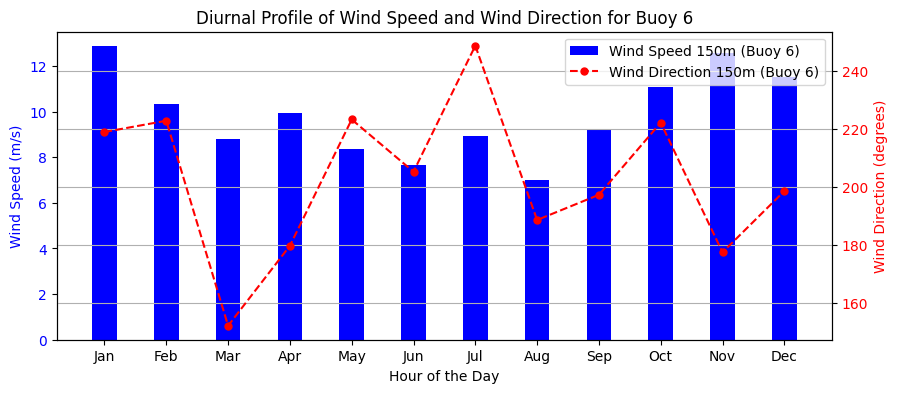

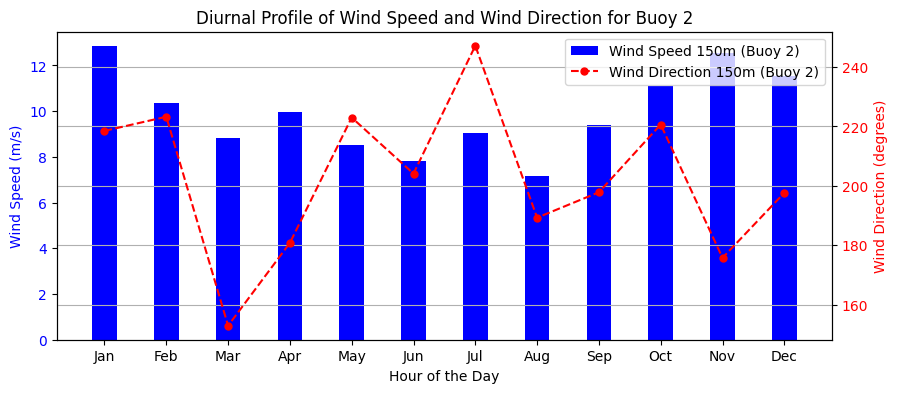

In [7]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot for Buoy 6
fig, ax1 = plt.subplots(figsize=(10, 4))

# Plot wind speed histogram on the left y-axis
ax1.bar(months, df_mounth_mean['ws6_150m'], width=0.4, label='Wind Speed 150m (Buoy 6)', color='b', align='center')
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Wind Speed (m/s)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis to plot wind direction
ax2 = ax1.twinx()
ax2.plot(months, df_mounth_mean['wd6_150m'], 'r--o', label='Wind Direction 150m (Buoy 6)', markersize=5)
ax2.set_ylabel('Wind Direction (degrees)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Title and grid
plt.title('Diurnal Profile of Wind Speed and Wind Direction for Buoy 6')
plt.grid(True)

plt.show()

# Plot for Buoy 2
fig, ax1 = plt.subplots(figsize=(10, 4))

# Plot wind speed histogram on the left y-axis
ax1.bar(months, df_mounth_mean['ws2_150m'], width=0.4, label='Wind Speed 150m (Buoy 2)', color='b', align='center')
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Wind Speed (m/s)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis to plot wind direction
ax2 = ax1.twinx()
ax2.plot(months, df_mounth_mean['wd2_150m'], 'r--o', label='Wind Direction 150m (Buoy 2)', markersize=5)
ax2.set_ylabel('Wind Direction (degrees)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Title and grid
plt.title('Diurnal Profile of Wind Speed and Wind Direction for Buoy 2')
plt.grid(True)

plt.show()


#### 19. Group the data into hours of the day and calculate the mean wind speed and wind direction for each hour of the day
#### 20. Plot the diurnal wind speed and wind direction for both buoys

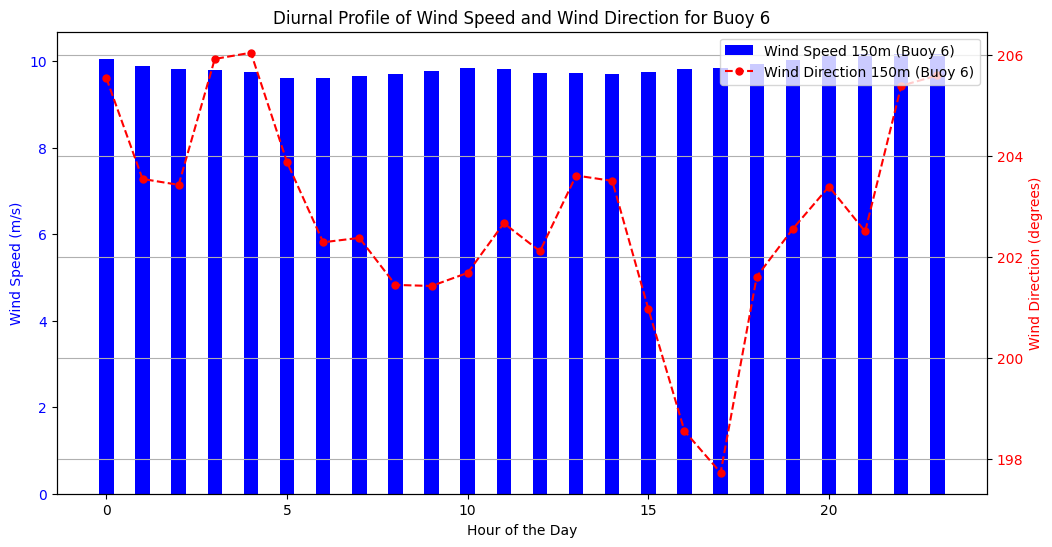

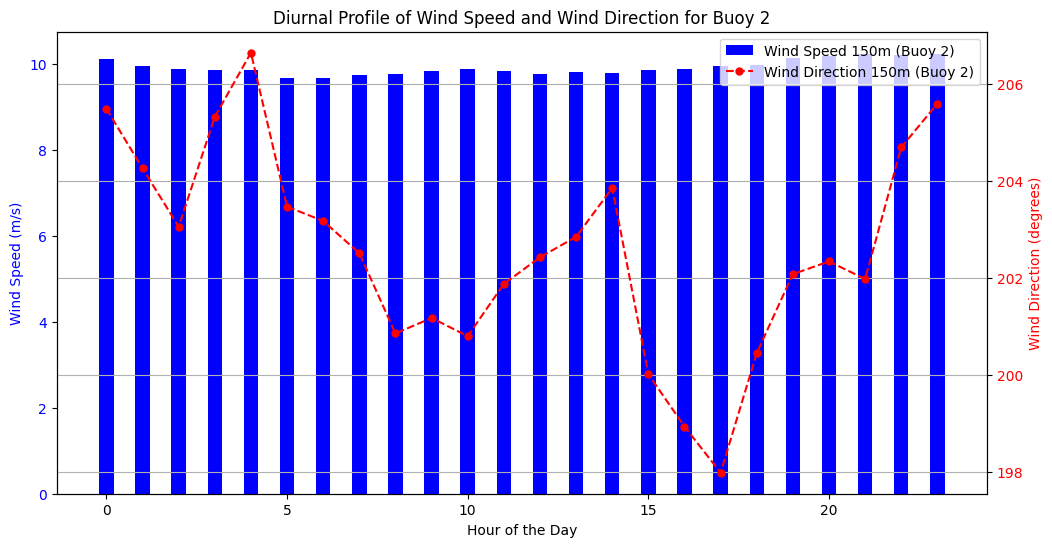

In [8]:
# Group by hour and calculate the mean wind speed and direction for each hour
df_interpol_height.index = pd.to_datetime(df_interpol_height.index)
df_interpol_height['hour'] = df_interpol_height.index.hour
diurnal_profile = df_interpol_height.groupby('hour').mean()

# Plot for Buoy 6
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot wind speed histogram on the left y-axis
ax1.bar(diurnal_profile.index, diurnal_profile['ws6_150m'], width=0.4, label='Wind Speed 150m (Buoy 6)', color='b', align='center')
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Wind Speed (m/s)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis to plot wind direction
ax2 = ax1.twinx()
ax2.plot(diurnal_profile.index, diurnal_profile['wd6_150m'], 'r--o', label='Wind Direction 150m (Buoy 6)', markersize=5)
ax2.set_ylabel('Wind Direction (degrees)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Title and grid
plt.title('Diurnal Profile of Wind Speed and Wind Direction for Buoy 6')
plt.grid(True)

plt.show()

# Plot for Buoy 2
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot wind speed histogram on the left y-axis
ax1.bar(diurnal_profile.index, diurnal_profile['ws2_150m'], width=0.4, label='Wind Speed 150m (Buoy 2)', color='b', align='center')
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Wind Speed (m/s)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis to plot wind direction
ax2 = ax1.twinx()
ax2.plot(diurnal_profile.index, diurnal_profile['wd2_150m'], 'r--o', label='Wind Direction 150m (Buoy 2)', markersize=5)
ax2.set_ylabel('Wind Direction (degrees)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Title and grid
plt.title('Diurnal Profile of Wind Speed and Wind Direction for Buoy 2')
plt.grid(True)

plt.show()


#### 21. Perform some checks on the grouping

In [9]:
#check if groupby does what it should manually 
# df_hourly = df_interpol_height.resample('h').mean()
# df_filtered1hour = df_hourly[df_hourly.index.strftime('%H:%M:%S') == '00:00:00'].mean()
# print(df_filtered1hour)
# print(diurnal_profile)

#print the 'hour' group to see that it marks one hour and then the next and so on 
# pd.set_option('display.max_rows', None)
# print(df_interpol_height['hour'])


#### 22. Plot wind roses for both buoys

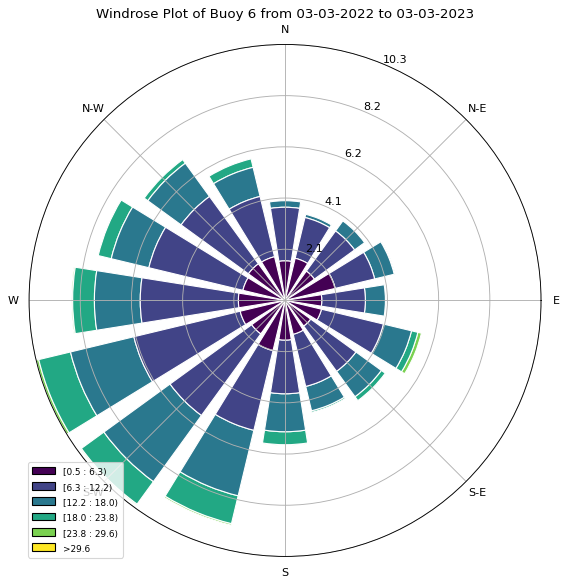

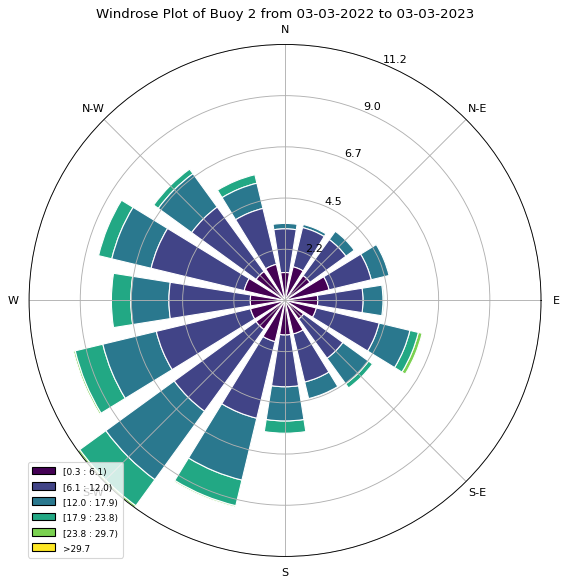

In [10]:

def plot_wind_rose(wd, ws, title):
    ax = WindroseAxes.from_ax()
    ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
    ax.set_legend()
    plt.title(title)
    plt.show()

plot_wind_rose(df_interpol_height['wd6_150m'], df_interpol_height['ws6_150m'], 'Windrose Plot of Buoy 6 from 03-03-2022 to 03-03-2023' )
plot_wind_rose(df_interpol_height['wd2_150m'], df_interpol_height['ws2_150m'], 'Windrose Plot of Buoy 2 from 03-03-2022 to 03-03-2023' )

#### 23. Plot a Weibull distribution of the wind speed

- weibull_min.fit(ws_data, floc=0): This part of the code fits a Weibull distribution to the wind speed data (ws_data). The fit method of the weibull_min distribution estimates the shape, location, and scale parameters of the Weibull distribution that best fit the provided data.
- shape, _, scale: The result of the fit method is a tuple containing the estimated parameters. In this case, shape represents the shape parameter of the Weibull distribution, and scale represents the scale parameter. The underscore _ is used to discard the estimated location parameter (floc), as it is fixed at 0 in this case.
- The weibull_pdf function defines the probability density function (PDF) for a Weibull distribution. function that describes the likelihood of a continuous random variable falling within a particular range of values.

#### 24. Calculate the annual power production of one turbine, one field, and the entire farm

Remark on wind turbine data: The "ct" in the turbine data refers to the thrust coefficient. It is a dimensionless number that describes the thrust force exerted by the wind on the turbine blades relative to the dynamic pressure of the wind.

APP of one Turbine: 79.3358 GWh
Estimated error: 0.0007 GWh
Annual Energy Production of N-9.1 (133 Turbines): 10.5517 TWh
Annual Energy Production of N-9.2 (133 Turbines): 10.5517 TWh
Annual Energy Production of N-9.3 (100 Turbines): 7.9336 TWh
Total Energy Production of all three fields (366 Turbines): 29.0369 TWh 
This is 5.73 % of the electricity consumed in one yr in Germany.


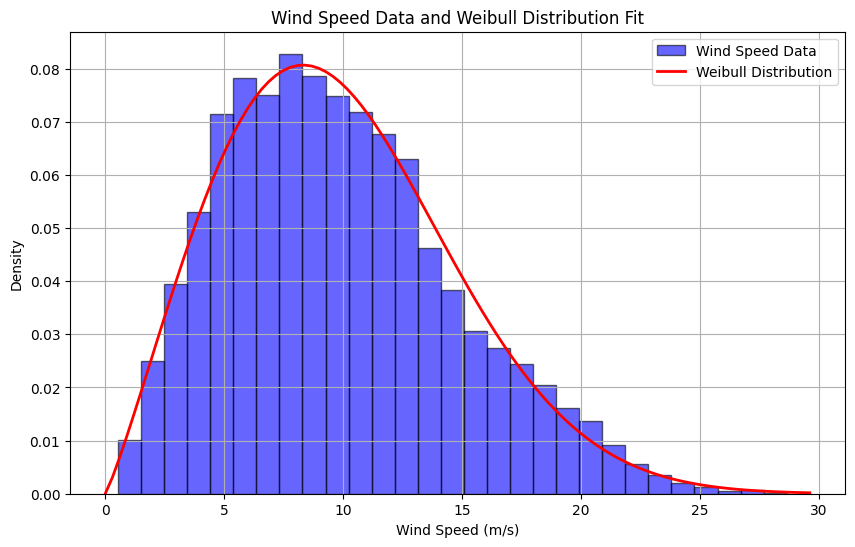

In [11]:
# Constants
T = 8760  # total hours/year [h]
rho = 1.225  # air density [kg/m^3]
D = 240  # rotor diameter [m]
A = np.pi * (D / 2)**2  # swept area [m^2]

# Load data
windspeed_data = df_interpol_height['ws6_150m']
power_curve_data = pd.read_csv(turbine_power_curve_path)

def cut_in_windspeed(power_curve_data):
    return power_curve_data.loc[power_curve_data['P'] > 0, 'ws'].min()

def cut_out_windspeed(power_curve_data):
    return power_curve_data.loc[power_curve_data['P'] > 0, 'ws'].max()

def power_curve_interpolated(power_curve_data):
    power_curve_func = interp1d(power_curve_data['ws'], power_curve_data['P'], fill_value="extrapolate")
    return power_curve_func

def calculate_weibull_fit(windspeed_data):
    shape, _, scale = weibull_min.fit(windspeed_data, floc=0)  # floc=0 => location parameter defaults to 0
    return shape, scale

def weibull_pdf(ws, shape, scale):
    return weibull_min.pdf(ws, shape, loc=0, scale=scale)

def integrand(ws, shape, scale, power_curve_func):
    P = power_curve_func(ws)  # Use interpolated power curve values
    return P * weibull_pdf(ws, shape, scale)

def calculate_APP(shape, scale, power_curve_func, cut_in_ws, cut_out_ws):
    APP, error = quad(integrand, cut_in_ws, cut_out_ws, args=(shape, scale, power_curve_func), limit=100, epsabs=1e-05, epsrel=1e-05)
    return APP * T, error * T  # Multiply by total hours per year to get AEP

# Process data
cut_in_ws = cut_in_windspeed(power_curve_data)
cut_out_ws = cut_out_windspeed(power_curve_data)
power_curve_func = power_curve_interpolated(power_curve_data)
shape, scale = calculate_weibull_fit(windspeed_data)

# Calculate APP (Annual Power Production)
APP, error = calculate_APP(shape, scale, power_curve_func, cut_in_ws, cut_out_ws)
print(f"APP of one Turbine: {APP / 1e6:.4f} GWh")  # Convert to MWh for readability
print(f"Estimated error: {error / 1e6:.4f} GWh")


print(f"Annual Energy Production of N-9.1 (133 Turbines): {((APP/1e9) * turbines_N9_1):.4f} TWh")
print(f"Annual Energy Production of N-9.2 (133 Turbines): {((APP/1e9) * turbines_N9_2):.4f} TWh")
print(f"Annual Energy Production of N-9.3 (100 Turbines): {((APP/1e9) * turbines_N9_3):.4f} TWh")
print(f"Total Energy Production of all three fields (366 Turbines): {((APP/1e9) *366):.4f} TWh ")
print(f"This is {((((APP/1e9) *366)/507)*100):.2f} % of the electricity consumed in one yr in Germany.")

# Plotting the Weibull distribution and wind speed data
plt.figure(figsize=(10, 6))
ws_range = np.linspace(0, max(windspeed_data), 100)
weibull_pdf_values = weibull_pdf(ws_range, shape, scale)

plt.hist(windspeed_data, bins=30, density=True, alpha=0.6, color='blue', edgecolor='black', label='Wind Speed Data')
plt.plot(ws_range, weibull_pdf_values, 'r-', lw=2, label='Weibull Distribution')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Density')
plt.title('Wind Speed Data and Weibull Distribution Fit')
plt.legend()
plt.grid(True)
plt.show()

#### 25. Plot a power curve

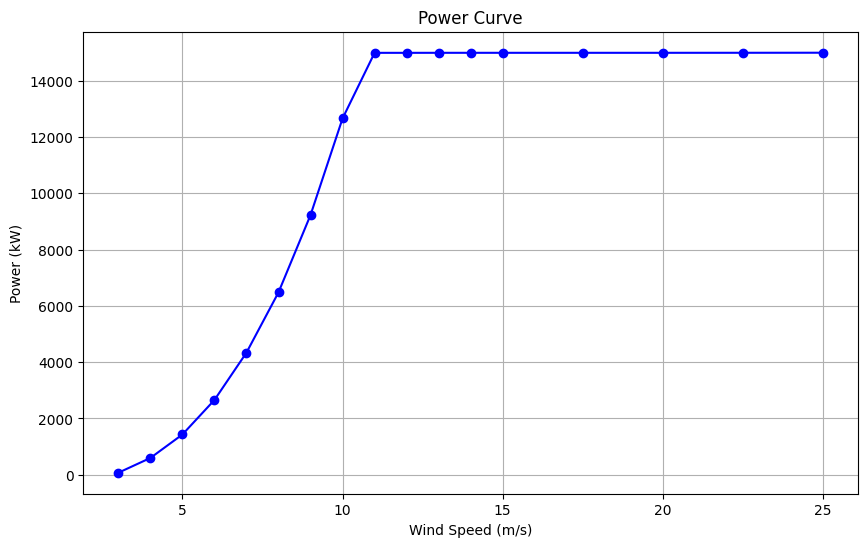

In [12]:
# Plotting the power curve
plt.figure(figsize=(10, 6))
plt.plot(power_curve_data['ws'], power_curve_data['P'], marker='o', linestyle='-', color='b')
plt.title('Power Curve')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.grid(True)
plt.show()